In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

In [ ]:
# data:  https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data
# refs:
# https://www.kaggle.com/code/jesucristo/fraud-complete-eda#Data
# https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets/notebook#Equally-Distributing-and-Correlating:
# https://www.kaggle.com/code/cdeotte/xgb-fraud-with-magic-0-9600
# https://www.kaggle.com/code/cdeotte/rapids-feature-engineering-fraud-0-96

dtypes = {"Time": np.uint32,
          "Class": np.bool}

data = pd.read_csv("../data/creditcard.csv", dtype=dtypes)

In [256]:
data["isFraud"] = data["Class"]
data.drop("Class", axis=1, inplace=True)
print(data.info(memory_usage="deep"))

dulicates = len(data[data.duplicated()])
print(f"{dulicates} duplicates were removed")
data = data.drop_duplicates(keep="first")

display(data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   Time     284807 non-null  uint32 
 1   V1       284807 non-null  float64
 2   V2       284807 non-null  float64
 3   V3       284807 non-null  float64
 4   V4       284807 non-null  float64
 5   V5       284807 non-null  float64
 6   V6       284807 non-null  float64
 7   V7       284807 non-null  float64
 8   V8       284807 non-null  float64
 9   V9       284807 non-null  float64
 10  V10      284807 non-null  float64
 11  V11      284807 non-null  float64
 12  V12      284807 non-null  float64
 13  V13      284807 non-null  float64
 14  V14      284807 non-null  float64
 15  V15      284807 non-null  float64
 16  V16      284807 non-null  float64
 17  V17      284807 non-null  float64
 18  V18      284807 non-null  float64
 19  V19      284807 non-null  float64
 20  V20      284807 non-null  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,isFraud
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,False
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,False
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,False
3,1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,False
4,2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,False


In [133]:
print("{}% of data missing".format(data.isna().sum().sum() / np.prod(data.shape) * 100))

0.0% of data missing


In [124]:
fraud_percentage = data["isFraud"].value_counts(normalize=True) * 100
print("Not Frauds: {:.2f}% of the dataset".format(fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the dataset".format(fraud_percentage.iloc[1]))

Not Frauds: 99.83% of the dataset
Frauds: 0.17% of the dataset


In [135]:
print(data.describe())

                Time             V1             V2             V3  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean    94811.077600       0.005917      -0.004135       0.001613   
std     47481.047891       1.948026       1.646703       1.508682   
min         0.000000     -56.407510     -72.715728     -48.325589   
25%     54204.750000      -0.915951      -0.600321      -0.889682   
50%     84692.500000       0.020384       0.063949       0.179963   
75%    139298.000000       1.316068       0.800283       1.026960   
max    172792.000000       2.454930      22.057729       9.382558   

                  V4             V5             V6             V7  \
count  283726.000000  283726.000000  283726.000000  283726.000000   
mean       -0.002966       0.001828      -0.001139       0.001801   
std         1.414184       1.377008       1.331931       1.227664   
min        -5.683171    -113.743307     -26.160506     -43.557242   
25%        -0.850134      -0.6898

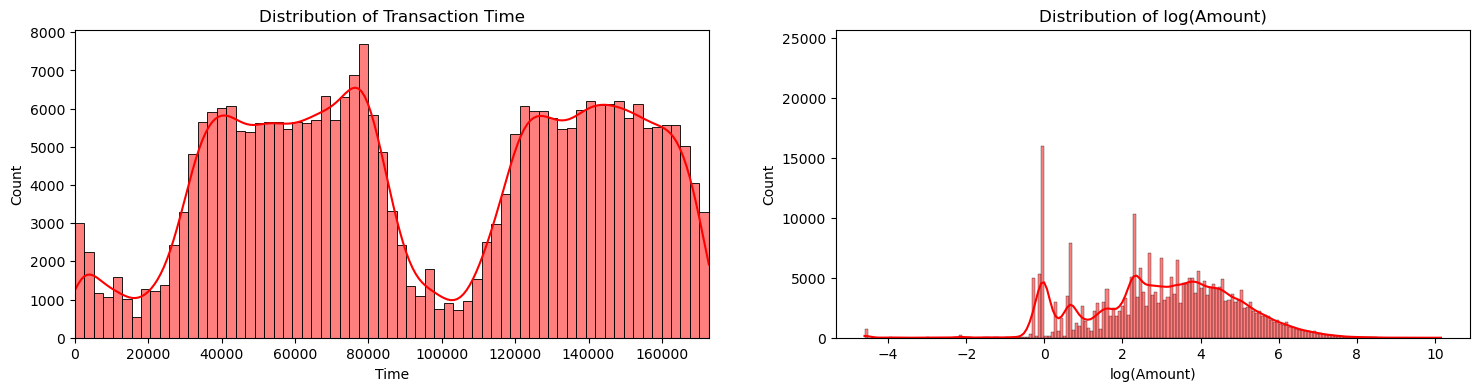

1419803

In [136]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

time_values = data["Time"].values
amount_values = data["Amount"].values

sns.histplot(time_values, ax=ax[0], kde=True, color="red")
ax[0].set_title("Distribution of Transaction Time")
ax[0].set_xlabel("Time")
ax[0].set_xlim([min(time_values), max(time_values)])

sns.histplot(np.log(amount_values), kde=True, ax=ax[1], color="r")
ax[1].set_title("Distribution of log(Amount)")
ax[1].set_xlabel("log(Amount)")
ax[1].set_ylim([min(amount_values), max(amount_values)])

plt.show()

del time_values, amount_values
gc.collect()


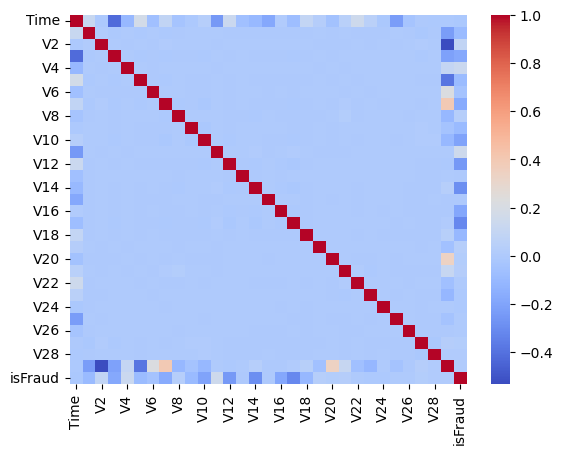

Series([], dtype: int64)


In [137]:
corr = data.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm')
plt.show()

high_corr = (corr.abs() > 0.90).sum()
print(high_corr[high_corr > 1])

In [138]:
from sklearn.utils import resample

fraud = data[data['isFraud'] == 1]
nonfraud = data[data['isFraud'] == 0]

nonfraud_downsampled = resample(
    nonfraud,
    replace=False,
    n_samples=len(fraud),
    random_state=11
)

data_downsampled = pd.concat([fraud, nonfraud_downsampled])
target_corr = data_downsampled.corr()["isFraud"]
print(np.array(target_corr.values))
high_corr = (target_corr.abs() > 0.90).sum()
print(high_corr[high_corr > 1])

[-0.11435362 -0.40929484  0.47799832 -0.56253249  0.70497684 -0.35449385
 -0.41934762 -0.46899623  0.10848585 -0.55490032 -0.62496601  0.67127461
 -0.67305294 -0.08278736 -0.74621157 -0.02930818 -0.5872392  -0.54843318
 -0.4603094   0.24863006  0.18549713  0.12880255  0.05195449 -0.04151748
 -0.0871065   0.00687404  0.06837129  0.13021699  0.0859445   0.06523872
  1.        ]
[]


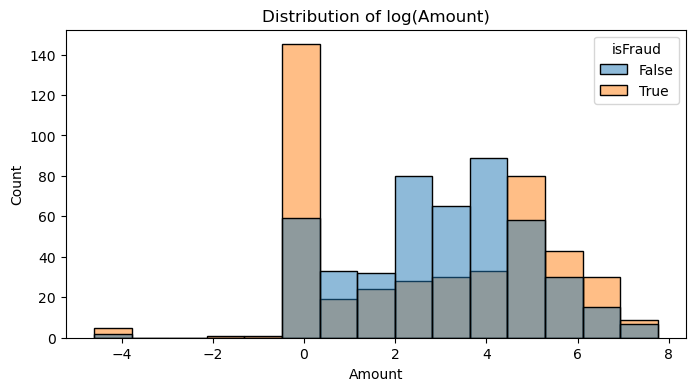

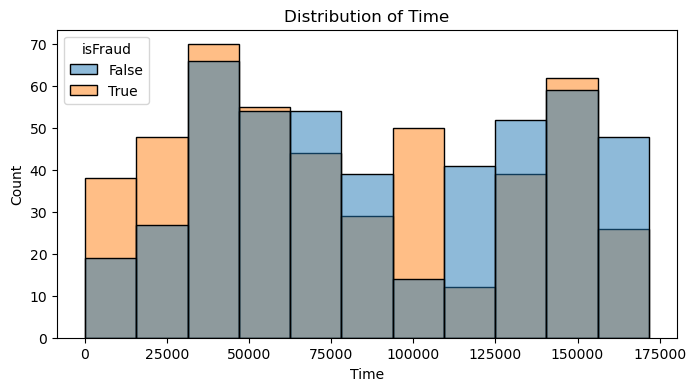

In [139]:
plt.figure(figsize=(8,4))
sns.histplot(data=data_downsampled, x=np.log(data_downsampled["Amount"]), color="red", hue="isFraud")
plt.title("Distribution of log(Amount)")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data=data_downsampled, x=data_downsampled["Time"], color="red", hue="isFraud")
plt.title("Distribution of Time")
plt.show()

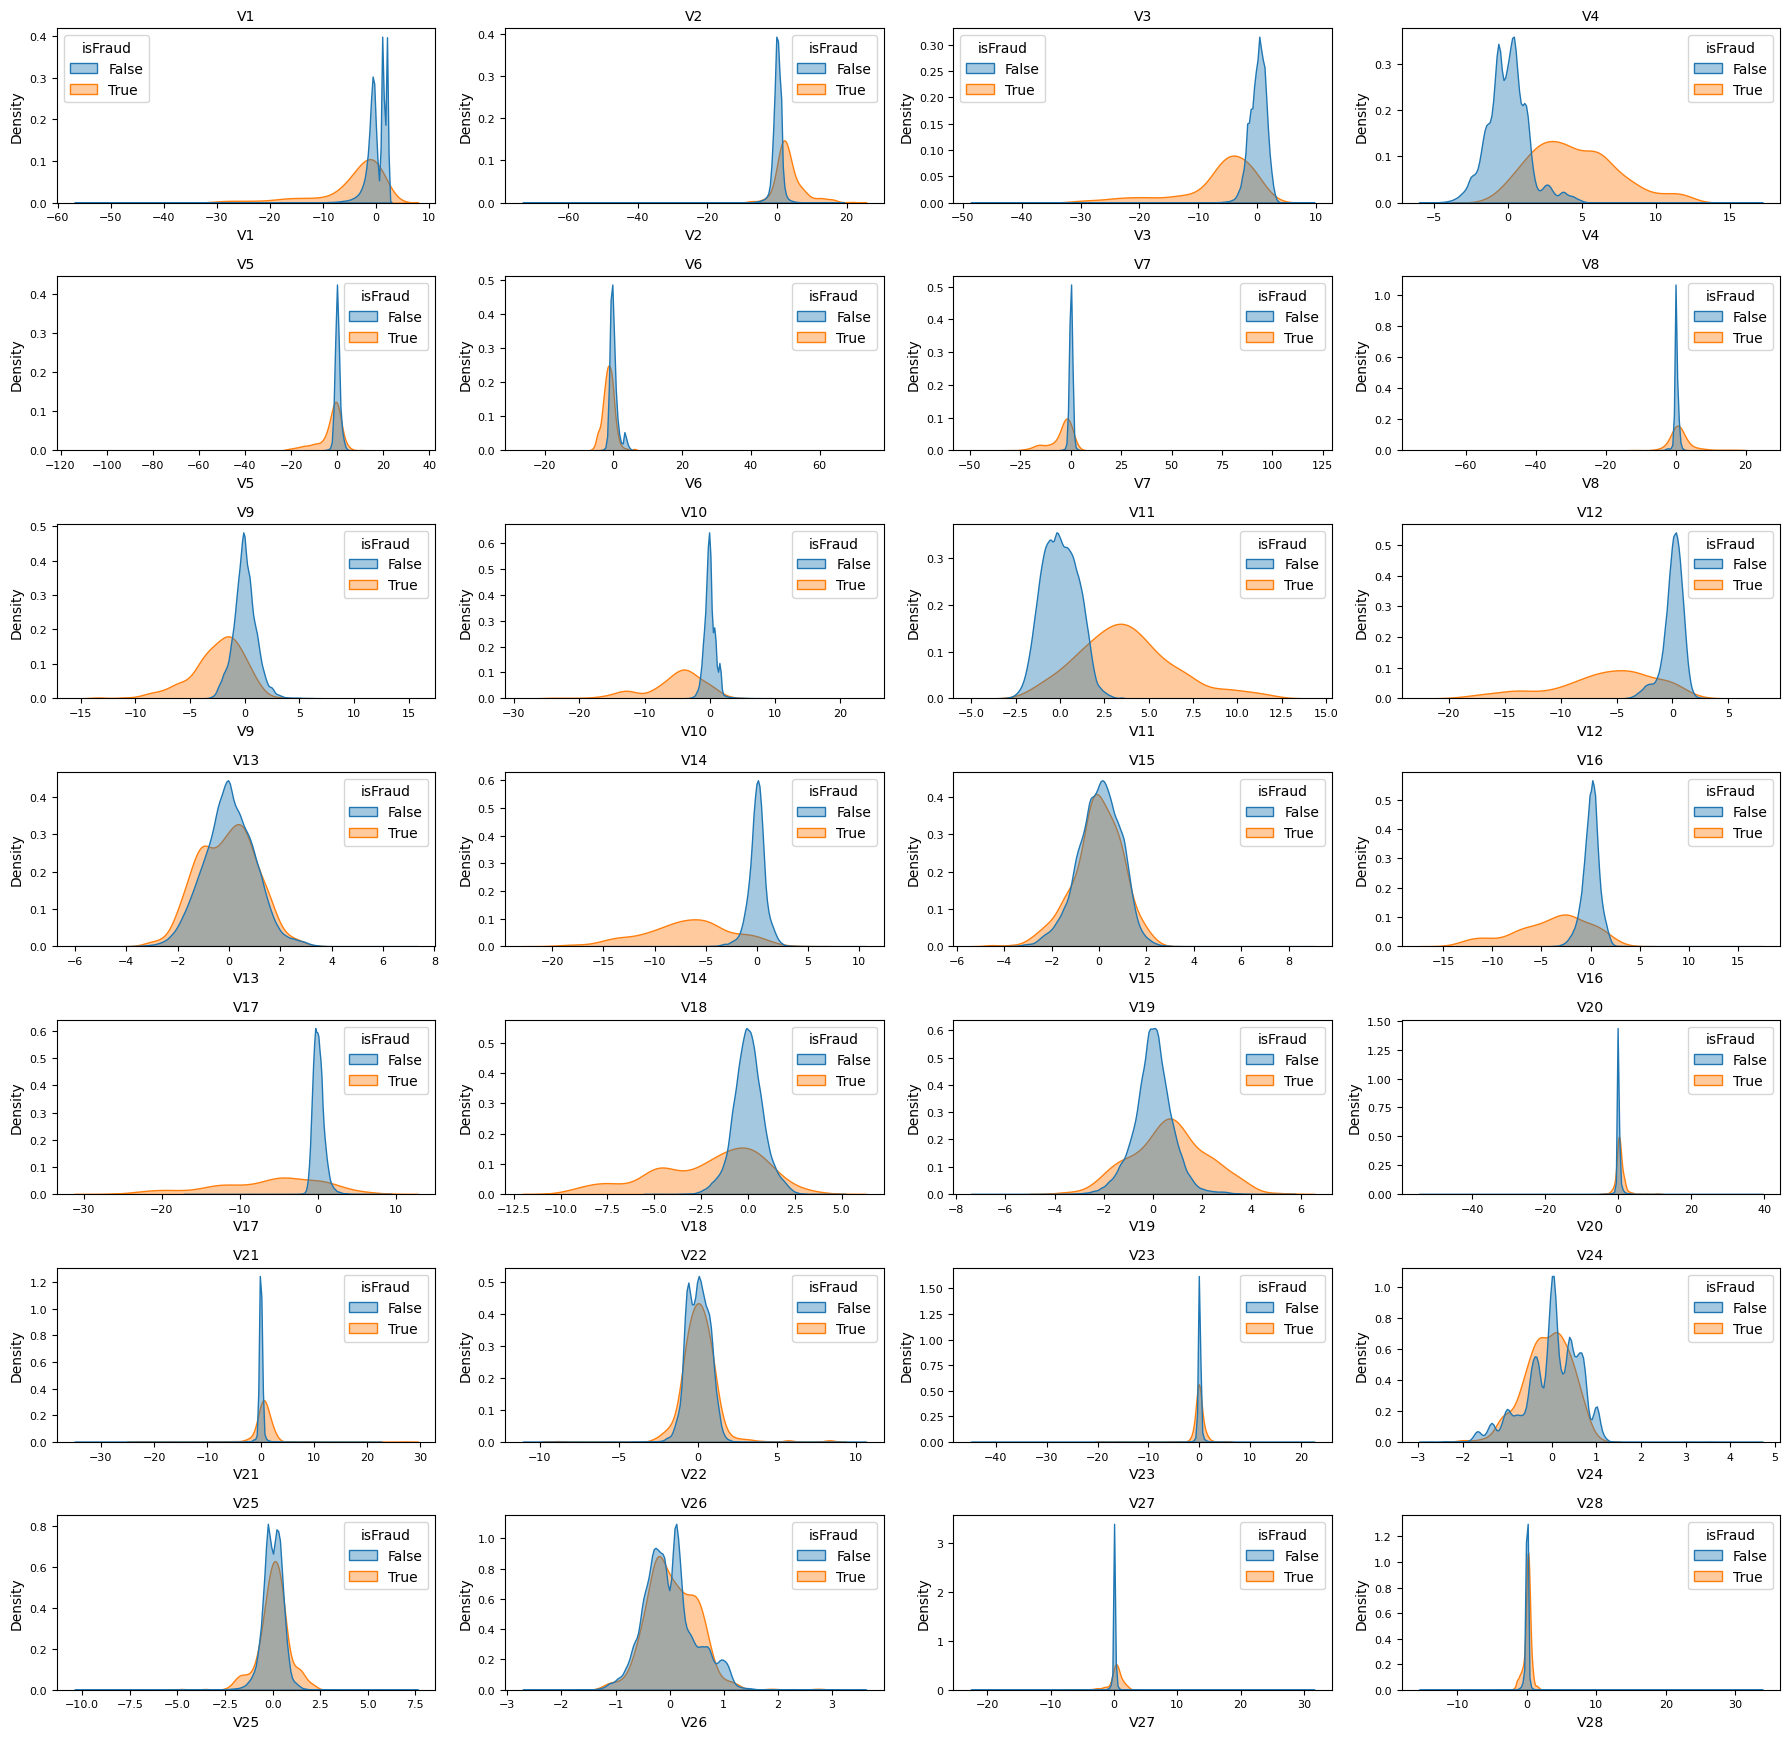

In [ ]:
v_features = [f"V{i}" for i in range(1, 29)]
n_cols = 4
n_rows = (len(v_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 2.5))
axes = axes.flatten()

for i, col in enumerate(v_features):
    ax = axes[i]
    sns.kdeplot(
        data=data,
        x=col,
        hue='isFraud',
        common_norm=False,
        fill=True,
        alpha=0.4,
        ax=ax,
        linewidth=1
    )
    ax.set_title(col, fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)


plt.tight_layout()
plt.show()


In [261]:
%%time
from sklearn.model_selection import train_test_split, StratifiedKFold

X = data.drop(["isFraud"], axis=1)
y = data["isFraud"]

train_size = int(0.8 * len(data))
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

train_fraud_percentage = y_train.value_counts(normalize=True) * 100
test_fraud_percentage = y_test.value_counts(normalize=True) * 100

print("Not Frauds: {:.2f}% of the train set".format(train_fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the train set".format(train_fraud_percentage.iloc[1]),'\n')

print("Not Frauds: {:.2f}% of the test set".format(test_fraud_percentage.iloc[0]))
print("Frauds: {:.2f}% of the test set".format(test_fraud_percentage.iloc[1]), '\n')



scv = StratifiedKFold(n_splits=4, shuffle=True, random_state=11)

for fold, (train_idx, val_idx) in enumerate(scv.split(X_train, y_train)):
    X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
    X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

    _, train_count = np.unique(y_tr, return_counts=True)
    _, valid_count = np.unique(y_val, return_counts=True)
    print(f"fold {fold+1} -", f"train: {train_count / sum(train_count)}", f"valid: {valid_count / sum(valid_count)}")

del train_fraud_percentage, test_fraud_percentage
h = gc.collect()



Not Frauds: 99.82% of the train set
Frauds: 0.18% of the train set 

Not Frauds: 99.87% of the test set
Frauds: 0.13% of the test set 

fold 1 - train: [0.99823773 0.00176227] valid: [0.99825535 0.00174465]
fold 2 - train: [0.9982436 0.0017564] valid: [0.99823773 0.00176227]
fold 3 - train: [0.9982436 0.0017564] valid: [0.99823773 0.00176227]
fold 4 - train: [0.9982436 0.0017564] valid: [0.99823773 0.00176227]
CPU times: total: 406 ms
Wall time: 412 ms


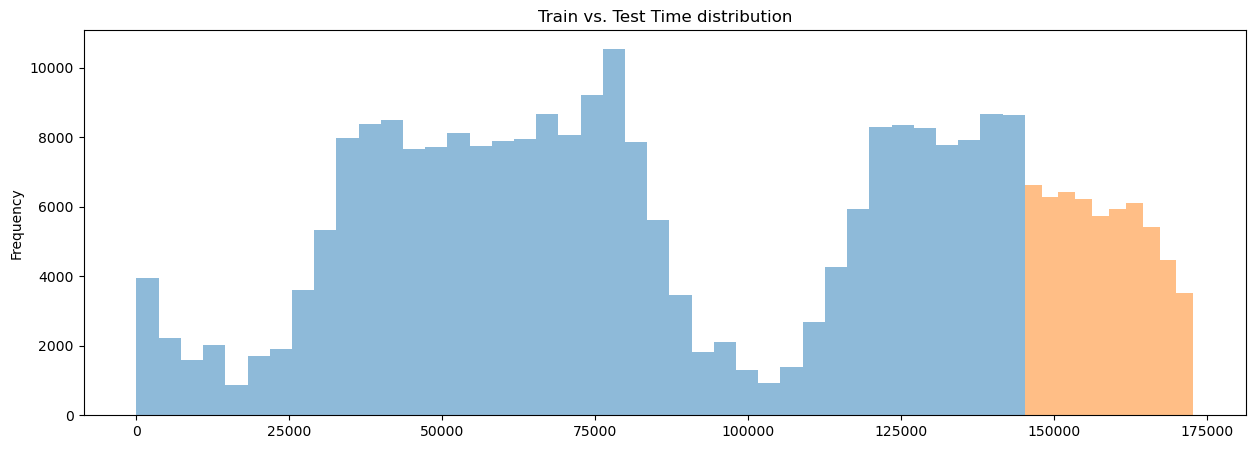

In [158]:
# fig, ax = plt.subplots(1, 2, figsize=(18,4))


# sns.histplot(X_train["Time"], ax=ax[0], kde=True, color="red")
# ax[0].set_title("Distribution of Transaction Time")
# ax[0].set_xlabel("Time")


# sns.histplot(X_test["Time"], kde=True, ax=ax[1], color="r")
# ax[1].set_title("Distribution of log(Amount)")
# ax[1].set_xlabel("log(Amount)")

X_train["Time"].plot(kind="hist",
                     figsize=(15, 5),
                     label="train",
                     bins=40,
                     alpha=0.5,
                     title="Train vs. Test Time distribution")
X_test["Time"].plot(kind="hist",
                     figsize=(15, 5),
                     label="test",
                     alpha=0.5)

plt.show()

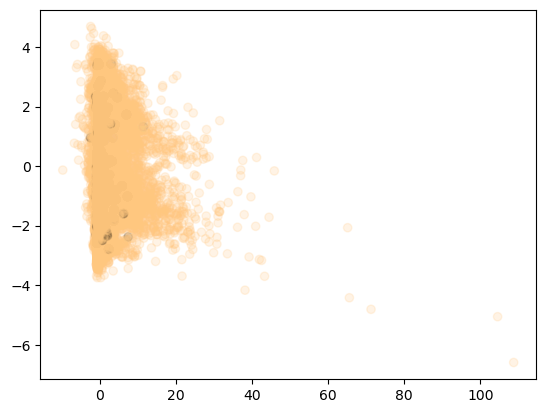

In [271]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_train_scaled = StandardScaler().fit_transform(X_train)
pca = PCA(n_components=2)
PCA_train_x = pca.fit_transform(X_train_scaled)

plt.scatter(PCA_train_x[:, 0], PCA_train_x[:, 1], c=y_train, cmap="copper_r", alpha=0.2)
plt.show()


In [262]:
%%time

from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, recall_score, accuracy_score
from xgboost import XGBClassifier


other_features = X.drop(["Time", "Amount"], axis=1).columns.to_list()

model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    use_label_encoder=False,
    random_state=11,
    n_jobs=-1,
)

preprocessor = ColumnTransformer([
    ("time_preprocess", RobustScaler(), ["Time"]),
    ("amount_preprocess", StandardScaler(), ["Amount"]),
    ('pass', 'passthrough', other_features)
    ]
)

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("smote", SMOTE(random_state=11)),
    ("clf", model)
])

param_dist = {
    'clf__n_estimators': [100, 300, 500, 800, 1000],
    'clf__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'clf__max_depth': [3, 5, 7, 9, 11],
    'clf__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'clf__gamma': [0, 0.1, 0.3, 0.5, 1],
    'clf__min_child_weight': [1, 3, 5, 7, 10],
    'clf__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'clf__reg_lambda': [0.1, 1, 5, 10, 20]
}

scoring = {
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score, pos_label=1),
    'roc_auc': 'roc_auc'
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    cv=scv,
    scoring=scoring,
    refit='recall',
    verbose=2,
    n_jobs=-1,
    random_state=11
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV Recall:", search.cv_results_['mean_test_recall'][search.best_index_])
print("Best CV Accuracy:", search.cv_results_['mean_test_accuracy'][search.best_index_])
print("Best CV ROC-AUC:", search.cv_results_['mean_test_roc_auc'][search.best_index_])

Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best params: {'clf__subsample': 1.0, 'clf__reg_lambda': 0.1, 'clf__reg_alpha': 0, 'clf__n_estimators': 1000, 'clf__min_child_weight': 3, 'clf__max_depth': 3, 'clf__learning_rate': 0.01, 'clf__gamma': 0.3, 'clf__colsample_bytree': 1.0}
Best CV Recall: 0.8820454545454546
Best CV Accuracy: 0.9892721825711517
Best CV ROC-AUC: 0.9696921796205688
CPU times: total: 1min 43s
Wall time: 4min 36s


In [263]:
from sklearn.metrics import precision_recall_curve

best_model = search.best_estimator_
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_prob)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold (by F1): {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}, Recall: {recalls[best_idx]:.3f}")

y_pred_opt = (y_pred_prob >= best_threshold).astype(int)
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt, digits=3))

Best threshold (by F1): 0.983
Precision: 0.962, Recall: 0.689
[[56670     2]
 [   23    51]]
              precision    recall  f1-score   support

       False      1.000     1.000     1.000     56672
        True      0.962     0.689     0.803        74

    accuracy                          1.000     56746
   macro avg      0.981     0.845     0.901     56746
weighted avg      1.000     1.000     1.000     56746



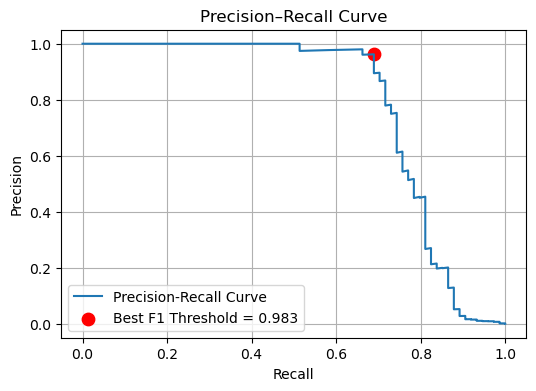

In [264]:
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.scatter(recalls[best_idx], precisions[best_idx], color='red', s=80,
            label=f'Best F1 Threshold = {best_threshold:.3f}')
plt.title('Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

In [265]:
target_recall = 0.7
idx = np.argmin(np.abs(recalls - target_recall))
target_threshold = thresholds[idx]
target_precision = precisions[idx]

print(f"Threshold for recall ~{target_recall}:", target_threshold)
print("Precision at this threshold:", target_precision)
print("Actual recall at this threshold:", recalls[idx])

Threshold for recall ~0.7: 0.95386255
Precision at this threshold: 0.8666666666666667
Actual recall at this threshold: 0.7027027027027027


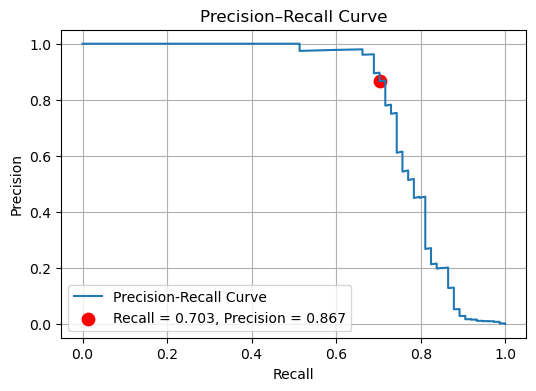

In [266]:
plt.figure(figsize=(6,4))
plt.plot(recalls, precisions, label='Precision-Recall Curve')
plt.scatter(recalls[idx], precisions[idx], color='red', s=80,
            label=f'Recall = {recalls[idx]:.3f}, Precision = {precisions[idx]:.3f}')
plt.title('Precision–Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()

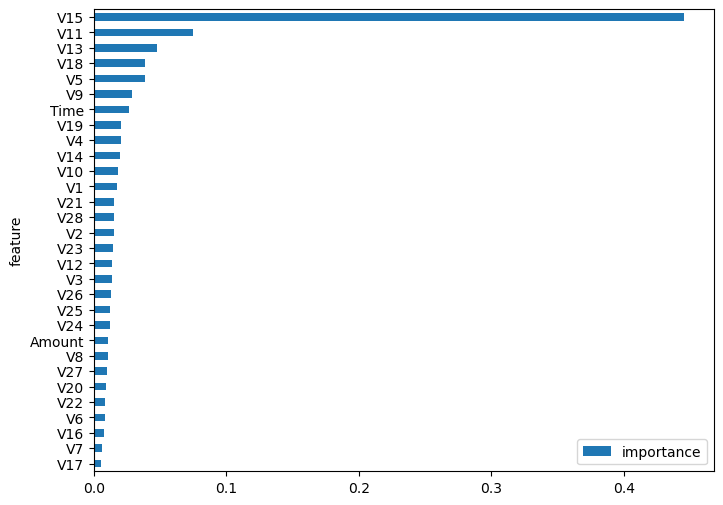

In [270]:
xgb_model = search.best_estimator_.named_steps['clf']

features = X_train.columns
importances = xgb_model.feature_importances_

fi_df = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values(by='importance', ascending=False)

fi_df.plot(kind="barh", x="feature", y="importance", figsize=(8,6))
plt.gca().invert_yaxis()
plt.show()